**<p style="text-align: center; font-size: 40px; font-family: 'Times New Roman';">FINDING HEAT FROM VELOCITY</p>**

**<p style="text-align: center; font-size: 20px; font-family: 'Times New Roman';">Amber Parker, Ilana Keselman, Mike Yan, Takumu Hamanaka</p>**

## Velocity Calculations

**Air density in Earth's atmosphere (below 100 km)** (Using Professor Wroblewski's code from AE202)

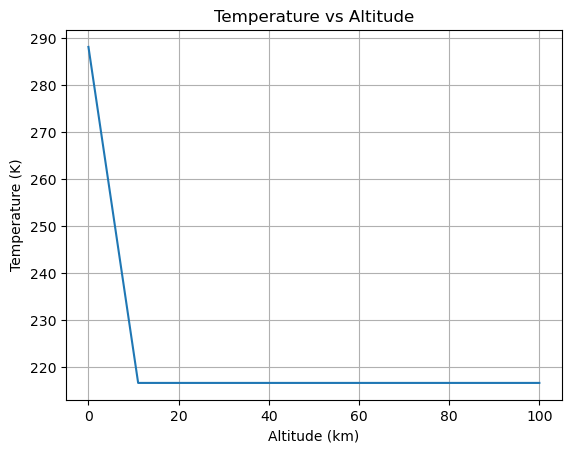

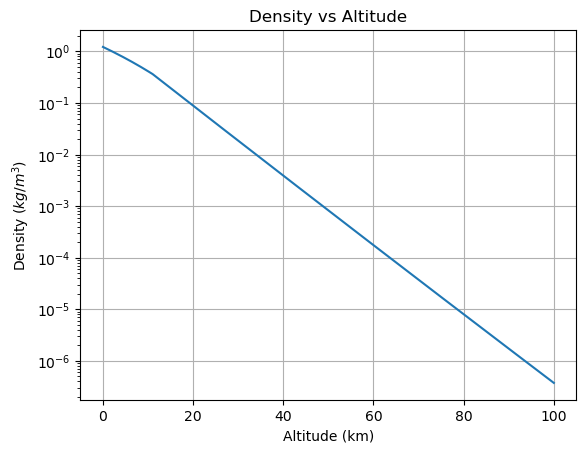

In [1]:
import numpy as np
import matplotlib.pyplot as plt

h_g = np.linspace(0, 100000, 500)  # Geopotential height from 0 to 100000 m (100 km)

def AtmosphereFunction(h_g):
    
    r_e= 6.371e6                        #earth's radius in meters
    R=287                               #m^2/K-sec, a constant
    g0=9.81                             #m/sec^2, gravity
    T0=288.15                           #degree K
    g_hG = g0 * (r_e / (r_e + h_g))**2  #gravity acceleration based on geopotential height
    h = (r_e / (r_e + h_g)) * h_g      #altitude from geopotenential altitude
    
    if h < 11000:                      #standard atmosphere math below the tropopause (m)
        h0 = 0                          #sea level altitude for comparison
        t0 = 288.15                     #sea level temperature for comparison in K
        P0 = 101325                     #sea level pressure for comparison in Pa
        rho0 = 1.225                    #sea level density for comparison in kg/m^3
        a1 = -6.5 * 10**(-3)                #temperature lapse rate in K/m
        T = T0 + a1 * (h - h0)          #temperature at altitude h
        P = P0 * (T / T0) ** (-g0 / (a1 * R))  #pressure from temperature
        rho = rho0 * (T / T0) ** (-(g0 / (a1 * R) + 1))  #density from temperature
    else:                               #standard atmosphere math above the tropopause (m)
        h0 = 11000                     #altitude at 11 km 
        P0 = 22632                  #pressure at 11 km in Pa
        rho0 = 3639 * 10**(-4)                #density at 11 km in kg/m^3
        T = 216.66                     #temperature is constant above 11 km
        P = P0 * np.exp(-g0 / (R * T) * (h - h0))  #pressure from temperature
        rho = rho0 * np.exp(-(g0 / (R * T) * (h - h0)))  #density from temperature
    
    mu0 = 1.7894e-5                    #viscosity at SL
    a = np.sqrt(1.4 * P/rho)           #speed of sound
    mu = mu0 * (T / T0) ** (1.5) * (T0 + 110.4) / (T + 110.4)  #viscosity from sutherland's formula
    return [h_g, h, T, P, rho, a, mu]

#T vs Altitude plot
T = [AtmosphereFunction(h)[2] for h in h_g]
plt.figure()
plt.plot(h_g / 1000, T)
plt.title('Temperature vs Altitude')
plt.xlabel('Altitude (km)')
plt.ylabel('Temperature (K)')
plt.grid()
plt.show()

#rho vs Altitude plot
rho = [AtmosphereFunction(h)[4] for h in h_g]
plt.figure()
plt.plot(h_g / 1000, rho)
plt.title('Density vs Altitude')
plt.xlabel('Altitude (km)')
plt.ylabel('Density $(kg/m^3)$')
plt.yscale('log')
plt.grid()
plt.show()

**Functions for $C_{P_{max}}$ and $C_d$**

M=2     Cp_max=1.66  Cd_wave≈1.10
M=3     Cp_max=1.76  Cd_wave≈1.17
M=5     Cp_max=1.81  Cd_wave≈1.21
M=10    Cp_max=1.83  Cd_wave≈1.22


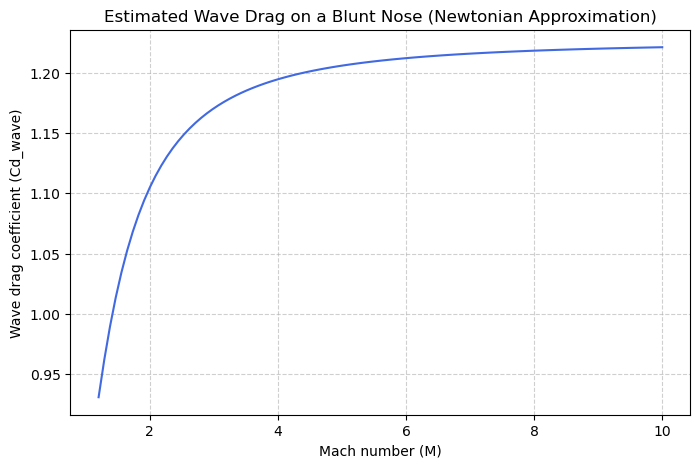

In [2]:
import numpy as np

def Cp_max(M, gamma=1.4):
    """Maximum pressure coefficient at stagnation point behind a normal shock."""
    p2_p1 = 1 + (2 * gamma / (gamma + 1)) * (M**2 - 1)
    M2_sq = (1 + 0.5 * (gamma - 1) * M**2) / (gamma * M**2 - 0.5 * (gamma - 1))
    p02_p2 = (1 + 0.5 * (gamma - 1) * M2_sq)**(gamma / (gamma - 1))
    p0_p1 = p2_p1 * p02_p2
    q_inf = 0.5 * gamma * M**2
    Cp = (p0_p1 - 1) / q_inf
    return Cp

def Cd(M, gamma=1.4):
    """Estimate wave drag coefficient for a blunt (hemispherical) nose."""
    Cp_stag = Cp_max(M, gamma)
    Cd_wave = (2/3) * Cp_stag  # Newtonian approximation for a hemisphere
    return Cd_wave

# Example usage
for M in [2, 3, 5, 10]:
    Cd_wave = Cd(M)
    print(f"M={M:<4}  Cp_max={Cp_max(M):.2f}  Cd_wave≈{Cd_wave:.2f}")



import matplotlib.pyplot as plt

M_values = np.linspace(1.2, 10, 100)
Cd_values = [Cd(M) for M in M_values]

plt.figure(figsize=(8,5))
plt.plot(M_values, Cd_values, color='royalblue')
plt.xlabel("Mach number (M)")
plt.ylabel("Wave drag coefficient (Cd_wave)")
plt.title("Estimated Wave Drag on a Blunt Nose (Newtonian Approximation)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

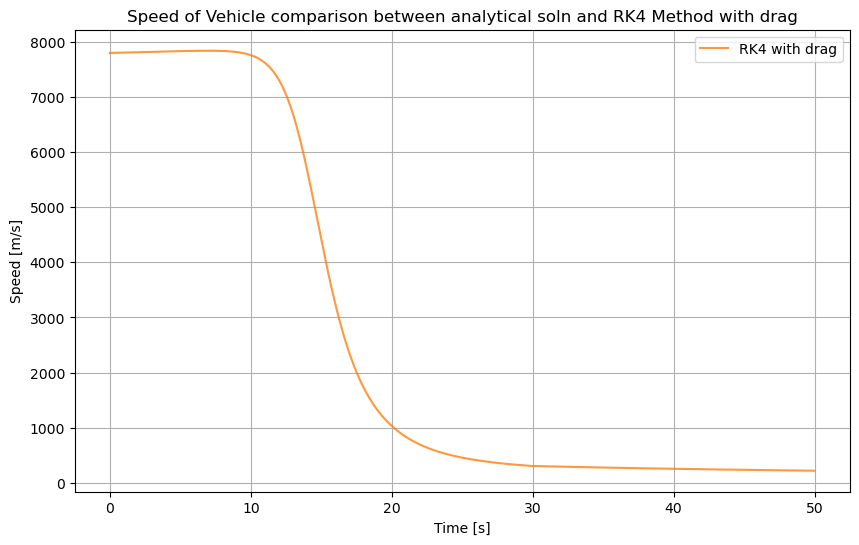

In [ ]:
#Your answer here
from sympy import*
u = symbols('u')

#Define Initial Conditions:
xi = [0.0, 100000.0] #m 
vi = [7800*np.sin(np.radians(45)), -7800*np.cos(np.radians(45))] #m/s  Reentry angle is 45 degrees

tlis = np.linspace(0, 50, 100000)
dt = tlis[1] - tlis[0]
u0 = np.array([xi[0], xi[1], vi[0], vi[1]])
g = 9.81 #gravitational constant
gma = 1.4 #specific heat ratio
R = 287 #mass based ideal gas constant for air

#Define right hand side of ODE for u 
def func(u):
    rho = AtmosphereFunction(u[1])[4] #kg/m^3 @ 200m
    T_y = AtmosphereFunction(u[1])[2]
    a = np.sqrt(gma*R*T_y)
    M = np.sqrt(u[2]**2 + u[3]**2)/a
    if M > 1:
        C = Cd(M) 
    else:
        C = 0.47 
    A = (2.2/2)**2 * np.pi #Using diameter of a Russian Soyuz capsule
    m = 2900 #kg, mass of Russian Soyuz capsule
    val = np.array([[0, 0, 1, 0], [0, 0, 0, 1], [0, 0, 0, 0], [0, 0, 0, 0]])@u + (((np.array([[0, 0, 1, 0], [0, 0, 0, 1], [0, 0, 0, 0], [0, 0, 0, 0]])@u).T@(np.array([[0, 0, 1, 0], [0, 0, 0, 1], [0, 0, 0, 0], [0, 0, 0, 0]])@u))**(1/2))*np.array([[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, -(rho*C*A)/(2*m), 0], [0, 0, 0, -(rho*C*A)/(2*m)]])@u + np.array([0, 0, 0, -g])
    return val

#Define RK4 function
def RK4(uk, dt):
    y1 = func(uk)
    y2 = func(uk + dt*y1/2)
    y3 = func(uk + dt*y2/2)
    y4 = func(uk + dt*y3)
    
    return uk + (y1 + 2*y2 + 2*y3 + y4)*dt/6

#Generating u data using RK4
ulis = [] 
uk = u0 
for i in range(len(tlis)):
    ukp1 = RK4(uk, dt) 
    ulis.append(ukp1)
    uk = ukp1

xlis_RK4 = []
ylis_RK4 = []
vlis = []
for i in ulis:
    xlis_RK4.append(float(i[0]))
    ylis_RK4.append(float(i[1]))
    vlis.append(np.sqrt(i[2]**2 + i[3]**2))

#plotting Results --------------------------------------------------------------------------------------------------------------------------
plt.figure(figsize=(10, 6))
plt.plot(tlis, vlis, label='RK4 with drag', color='tab:orange', alpha=0.8)
plt.xlabel('Time [s]')
plt.ylabel('Speed [m/s]')
plt.title('Speed of Vehicle comparison between analytical soln and RK4 Method with drag')
plt.legend()
plt.grid(True)
plt.show()



In [4]:
rho_list= []
for y in ylis_RK4:
    rho_list.append(AtmosphereFunction(y)[4])

a = []
for y in ylis_RK4:
    a.append(AtmosphereFunction(y)[5])
    
M = np.array(vlis) / np.array(a) 

cp_list = []
for mach in M:
    cp_list.append(Cp_max(mach))



def surface_energy_ode(t, T_w, R_n = 1.1, k_sg = 1.74e-4, m_s = 2900, eps = 0.8, return_qnet=False):
    """
    Computes dT_w/dt for a lumped surface thermal mass model.

    Parameters
    ----------
    t : float
        Current time [s]

    T_w : float  
        (surface temperature, K)
    
    params : dict
        Dictionary of required parameters:
            rho_inf : float   # local freestream density [kg/m^3]
            V_inf   : float   # local freestream velocity [m/s]
            R_n     : float   # nose radius [m]
            k_sg    : float   # Sutton–Graves constant [SI: W·m^0.5/(kg^0.5·m^2·s^3)]
            m_s     : float   # surface (lumped) mass [kg]
            c_p     : float   # specific heat [J/kg·K]
            eps     : float   # surface emissivity [-]
            sigma   : float   # Stefan–Boltzmann constant [W/m^2·K^4]
            q_rad_in : float  # optional external radiative heating [W/m^2] (default 0)
            return_qnet=False : bool  # if True, return net heat flux instead of dT/dt

    Returns
    -------
    dTdt : float
        Time derivative of surface temperature [K/s]
    """
    # unpack state
    rho = rho_list[t]
    V = vlis[t]
    c_p = cp_list[t]
    # unpack parameters
    sigma = 5.670374419e-8  # default Stefan-Boltzmann constant
    q_rad_in = 0.0

    # ---- Convective heat flux (Sutton–Graves) ----
    q_conv = k_sg * np.sqrt(rho / R_n) * V**3

    # ---- Reradiation heat flux ----
    q_rerad = eps * sigma * T_w**4

    # ---- Net energy balance ----
    q_net = q_conv + q_rad_in - q_rerad

    # ---- Temperature rate ----
    dTdt = q_net / (m_s * c_p)

    if return_qnet:
        return q_conv
    else:
        return dTdt


state_const = dict(R_n = 1.1, k_sg = 1.74e-4, m_s = 2900, eps = 0.8)

def RK4_solve(f, T_w, t, dt):
    
    y1 = f(t, T_w, **state_const)
    y2 = f(t, T_w + dt*y1/2, **state_const)
    y3 = f(t, T_w + dt*y2/2, **state_const)
    y4 = f(t, T_w + dt*y3, **state_const)
    

    return T_w + (y1 + 2*y2 + 2*y3 + y4)*dt/6

T = [] #[Kelvin]
T.append(216.66)
q = [] #[W/m^2]
q.append(surface_energy_ode(0,T[0], **state_const, return_qnet=True))

for i in range(len(tlis)-1):
    T.append(RK4_solve(surface_energy_ode, T[i], i, dt))
    q.append(surface_energy_ode(i,T[i], **state_const, return_qnet=True))




3508.711446816625
752.4211300365747


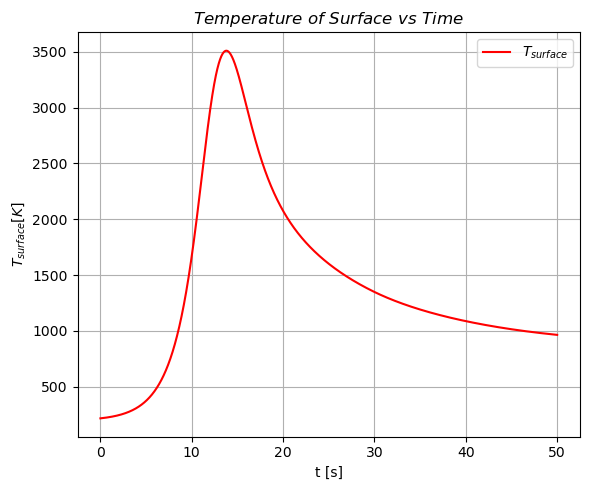

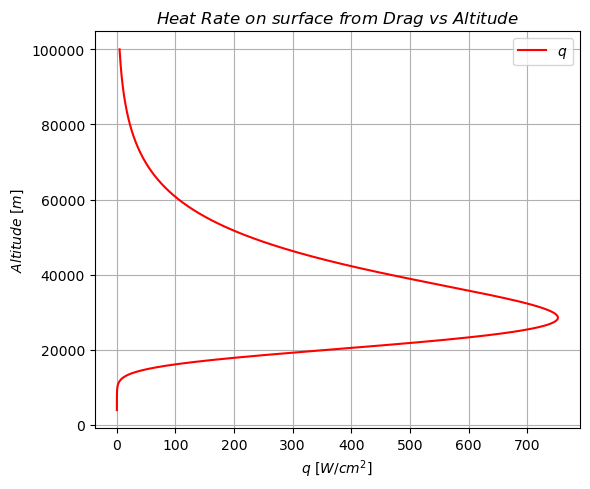

In [5]:
plt.figure(figsize=(6,5),tight_layout=True)

plt.plot(tlis, T, 'r-', label='$T_{surface}$')
plt.xlabel('t [s]')
plt.ylabel('$T_{surface} [K]$')
plt.title("$Temperature\ of\ Surface\ vs\ Time$")
plt.legend()
plt.grid(True)
    
plt.figure(figsize=(6,5),tight_layout=True)
plt.plot(np.array(q)/10**4, ylis_RK4, 'r-', label='$q$')
plt.xlabel('$q\ [W/cm^2]$')
plt.ylabel('$Altitude\ [m]$')
plt.title("$Heat\ Rate\ on\ surface\ from\ Drag\ vs\ Altitude$")
plt.legend()
plt.grid(True)
"""
ax1 = fig.add_subplot(513) 
ax1.plot(T, ylis_AB3, 'r-', label='$T_w$')
ax1.set_xlabel('$T [K]$')
ax1.set_ylabel('$Altitude [m]$')
ax1.set_title("$Heat\ Rate vs\ Altitude$")
ax1.legend()
plt.grid(True)

ax1 = fig.add_subplot(514) 
ax1.plot(xlis_AB3, ylis_AB3, 'r-', label='$T_w$')
ax1.set_xlabel('$x_x [m]$')
ax1.set_ylabel('$x_y [m]$')
ax1.set_title("Trajetory")
ax1.legend()
plt.grid(True)

ax1 = fig.add_subplot(515) 
ax1.plot(ylis_AB3, M, 'r-', label='$T_w$')
ax1.set_xlabel('$x_x [m]$')
ax1.set_ylabel('$x_y [m]$')
ax1.set_title("Trajetory")
ax1.legend()
plt.grid(True)
"""
print(max(T))
print(max(q)/10**4)


dt= 0.5    , Error=6.429e-05
dt= 0.25   , Error=4.045e-06
dt= 0.125  , Error=2.532e-07
dt= 0.0625 , Error=1.578e-08
dt= 0.03125, Error=9.486e-10


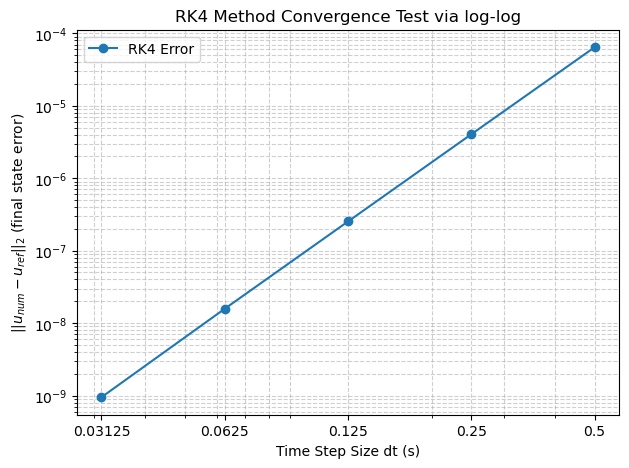

Estimated convergence slope: 4.01


In [6]:
# Error analysis for RK4

t_end = 5  # 5 seconds since 50 would be long for this test
dt_values = [.5, .25, .125, .0625, .03125] #time step sizes to test
dt_ref = dt_values [-1]/16 #reference time step for "exact" solution

#redefine initial conditions, just for fun
xi = [0.0, 100000.0] #m
vi = [7800/ np.sqrt(2), -7800/ np.sqrt(2)] #m/s
u0 = np.array([xi[0], xi[1], vi[0], vi[1]]) #initial state vector

#Integrate the equations of motion using RK4.
def integrate_RK4(u0, dt, t_end):
    n_steps = int(t_end / dt)
    u = u0.copy()
    for _ in range(n_steps):
        u = RK4(u, dt)
    return u # return final state vector

# Compute the reference solution
u_ref = integrate_RK4(u0, dt_ref, t_end)

#compute the errors for each dt value
errors = []

for dt in dt_values:
    u_num = integrate_RK4(u0, dt, t_end)
    err = np.linalg.norm(u_num - u_ref, ord=2)  # L2 norm of the error
    errors.append(err)
    print(f"dt={dt:< 8}, Error={err:.3e}") #print errors

    # Plotting the errors via log-log error vs dt
plt.figure(figsize=(7,5))
plt.loglog(dt_values, errors, 'o-', label='RK4 Error')
plt.xlabel('Time Step Size dt (s)')
plt.ylabel('$ ||u_{num} - u_{ref} ||_2 $ (final state error)')
plt.title('RK4 Method Convergence Test via log-log')
plt.grid(True, which="both", ls="--", alpha = 0.6)
plt.xticks(dt_values,dt_values)
plt.legend()
plt.show()

slope = (np.log(errors[-1]) - np.log(errors[0])) / (np.log(dt_values[-1]) - np.log(dt_values[0]))
print(f"Estimated convergence slope: {slope:.2f}")